# Environment

In [1]:
import gym
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid

In [2]:


class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.state_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            self.action_space = gym.spaces.Discrete(4)
            
            print("self.env", self.env)

        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = self.observation_space.n
        else:
            self._state_dim = len(observation)

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig = plt.figure(figsize=(5, 5))         
            plt.imshow(self.env.grid)
            plt.show()
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agent

In [3]:

class Agent:
    
    def __init__(self, enviroment, param={}):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        
        
        inputs = keras.Input(shape=(self._state_dim,), name="input")
        x = keras.layers.Dense(30, activation='relu', name="hidden_latent")(inputs)
        layer_latent = keras.layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
        layers_ouputs = {}

        for a in range(self._action_size) :
            name_a ="Fa{}".format(a)
            layers_ouputs[name_a] = keras.layers.Dense(self.dim_latent,use_bias=False,name=name_a+"_tranpose")(layer_latent)
            
        layers_ouputs["dot_reward"] = keras.layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
        
        layers_ouputs["phi"] = layer_latent
        
        self.model = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model")
        
        
        self.model_prev = keras.models.clone_model(self.model)

         # Initialize policy
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
                
    def choose_action(self, state, model, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy = self.choose_action_greedy(state, model, possible_action)
                
                return action_greedy, self.epsilon
            
            
    def choose_action_greedy(self, state, model, possible_action):
            
      
        Q_values = [self.Q_a(state.reshape(1, -1),a.reshape(1), model) for a in possible_action]
               
        return np.argmax(Q_values)

    
    def Fa(self, action, model) : 
        
        
        for idl, layer in enumerate(model.layers):
            name_a = "Fa{}_tranpose".format(action)
            if layer.name == name_a : 
                Fa_transpose = layer.weights[0]
                Fa = tf.transpose(Fa_transpose)
                
                return Fa
    
    
    def Fa_bar(self, action_space, model) : 
        
        Fa_add = self.Fa(action_space[0],model)
        
        for action in action_space[1:] : 
            Fa_add = tf.add( Fa_add, self.Fa(action,model) )
        
        Fa_moy = tf.divide(Fa_add, len(action_space))

        return Fa_moy
    
    
    def phi(self, states, model) : 
        return model(states)["phi"]
    
    
    def psi_a(self, states, actions, model) : 
                
        vector_phi = self.phi(states, model)
        
        batch_size = len(states)
        phi_size = len(vector_phi[0])

        psi_aggr = []

        
        
        
        for k, action in enumerate(actions) :  
            
            matrix_Fa = self.Fa( action, model)
            
            vector_phi_k = tf.reshape(vector_phi[k],[1,phi_size])
            
            psi_aggr.append( tf.matmul( vector_phi_k , matrix_Fa   )   )
            
        tensor_psi_a = tf.convert_to_tensor(psi_aggr)
        
        return tf.reshape(tensor_psi_a,[batch_size,phi_size])
                
        
    def psi_bar(self, states, action_space, model) : 
                
        vector_phi = self.phi(states, model)
        
        batch_size = len(states)
        phi_size = len(vector_phi[0])
        
        psi_aggr = []
        
        matrix_Fa_bar = self.Fa_bar( action_space, model)

        for k,state in enumerate(states) : 

            vector_phi_k = tf.reshape(vector_phi[k],[1,phi_size])
            
            psi_aggr.append( tf.matmul( vector_phi_k , matrix_Fa_bar   )   )
            
        tensor_psi_bar = tf.convert_to_tensor(psi_aggr)
        
        
        return tf.reshape(tensor_psi_bar,[batch_size,phi_size])
            
        
        
    
    def psi_bar_prev(self, states, action_space, model, model_prev) : 
                
        vector_phi = self.phi(states, model)
        
        batch_size = len(states)
        phi_size = len(vector_phi[0])
        
        psi_aggr = []
        
        matrix_Fa_bar = self.Fa_bar( action_space, model_prev)

        for k,state in enumerate(states) : 

            vector_phi_k = tf.reshape(vector_phi[k],[1,phi_size])
            
            psi_aggr.append( tf.matmul( vector_phi_k , matrix_Fa_bar   )   )
            
        tensor_psi_bar = tf.convert_to_tensor(psi_aggr)
        
        
        return tf.reshape(tensor_psi_bar,[batch_size,phi_size])
        
    def w_reward(self, model) : 
        for idl, layer in enumerate(model.layers):
            if layer.name == "dot_layer" : 
                return layer.weights[0]

        
        
    def Q_a(self, states, actions, model) : 
        
        batch_size = len(states)
        
        vector_batch_psi_a = self.psi_a(states, actions, model)
               
        w_layer = self.w_reward(model)
        
        w_layer_size = w_layer.shape[0]
        
        vector_reward =  tf.reshape(w_layer,[w_layer_size])
        
        Q_a_aggr = []
        
        for k in range(batch_size) : 
            Q_a_aggr.append(tf.tensordot( vector_batch_psi_a[k], vector_reward, 1))
            
        tensor_Q_a = tf.convert_to_tensor(Q_a_aggr)
        
        return tensor_Q_a
        
        
            
    def target_Q(self, model, states,actions, next_states,terminate,rewards, model_prev=None):
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  self.Q_a(states, rewards, model, actions)
        prim_qtp1 = self.Q_a(next_states, rewards, model, actions)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(BATCH_SIZE)

        if Q_model_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated

            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = Q_model_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q
            
    
    def target_psi(self, model, states,actions, next_states,terminate,rewards, model_prev, filter_done):
        
        #  sans model_prev : F_bar(model)
        #  avec model_prev : F_bar(model_prev)
        if model_prev is None:
            psi_bar = self.psi_bar(next_states, action_space, model) 
        else : 
            psi_bar = self.psi_bar_prev(next_states, action_space, model, model_prev)
            
        #  filter_done = True : - we don't take into account terminal states : 
        #                       - creation of a filter to determine whitch episode of batch is a terminal state
        #  filter_done = False : we take into account all states
        if filter_done  : 
            
            filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
            gamma_psibar = tf.multiply(
                            self.param["gamma"],
                            self.psi_bar(next_states, action_space, model) 
                    )
            product_filter_gamma_psibar = []
            for k in range(0,len(gamma_psibar)) :    
                product_filter_gamma_psibar.append(tf.math.scalar_mul(filter_idxs[k], gamma_psibar[k])  )
            product_filter_gamma_psibar_tensor = tf.convert_to_tensor(product_filter_gamma_psibar)
            
            y = tf.add(
                self.phi(states,model) , 
                product_filter_gamma_psibar_tensor
            )
            
        else : 
            
            y = tf.add(
                self.phi(states,model) , 
                tf.multiply(
                        self.param["gamma"],
                        self.psi_bar(next_states, action_space, model) 
                ) 
            )
            
        return y
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        
    def loss_N(self,y_pred) : 
        vector_ONE = tf.constant(1., shape=y_pred.shape[0], dtype = y_pred.dtype)
        loss =    tf.pow(tf.subtract(tf.norm(y_pred, axis=1), vector_ONE ), 2.) 
        return loss
        
    
    def train(self, model, memory, model_prev, filter_done):
        if memory.num_samples < BATCH_SIZE * 3:
            return 0
        batch = memory.sample(BATCH_SIZE)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[3]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))

        
        #         ************* A Calculate Loss on reward and normalisation first  *******************
        # A-1) calculate the losses 
            
        target_psi = self.target_psi(model, states,actions, next_states,terminate,rewards, model_prev, filter_done)
        
        
        alpha_r = self.param["loss"]["alpha_r"]
        alpha_N = self.param["loss"]["alpha_N"]
        alpha_psi = self.param["loss"]["alpha_psi"]  
        
        with tf.GradientTape() as tape:
            logits_r =  model(states)["dot_reward"]
            loss_r =  self.loss_mse(logits_r, rewards )

            logits_N = model(states)["phi"]
            loss_N =  self.loss_N(logits_N)

            logits_psi = self.psi_a(states, actions, model)
            loss_psi = self.loss_mse( logits_psi, target_psi )

            loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi
        
        
        
        # A-2) : calculate the gradient   
        
        grads = tape.gradient(loss_tot, model.trainable_weights) 
        
#         print("grads", grads)

        # A-3) : apply the gradient 
        
        self.param["optimizer"].apply_gradients(zip(grads, model.trainable_weights)) 
          
        #         ****************************************************

        if model_prev is not None:
            # update model_prev parameters slowly from model (primary network) 
            for t, e in zip(model_prev.trainable_variables, model.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        #         ************* MODIF GRADIENT-TAPE *******************
        return tf.reduce_mean(loss_tot).numpy()
        #         *****************************************************



# Storage

In [4]:

class Memory:
        
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

    @property
    def num_samples(self):
        return len(self._samples)


# Parameters

In [5]:

# param_env = {
#     "agent_pos":None, 
#     "goal_pos":[0, 7-1],
#     "grid_size" : 7,
#     "pattern":"random",
#     "obs_mode":"index",
# }
# env_name = "SimpleGrid"
# env = custom_env(env_name, param_env)

# env_name = "gym_NChain-v0"
# env = custom_env(env_name)


env_name = "gym_CartPole-v1"
env = custom_env(env_name)

    
BATCH_SIZE = 32
RANDOM_REWARD_STD = -1.0



opt = keras.optimizers.Adam()

loss = keras.losses.mean_squared_error

param_agent = {
    "optimizer": opt,
    "loss": {
        "alpha_r" : 1/3.,
        "alpha_N" : 1/3.,
        "alpha_psi" : 1/3.
    },
    "latent_space": 30,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "gamma": 0.95,
    "tau": 0.08,
}


memory = Memory(500000)

agent = Agent(env, param_agent)

num_episodes = 200
render = False


# STORE_PATH = '.'
# train_writer = tf.summary.create_file_writer(
#     STORE_PATH + f"/DoubleQ_{dt.datetime.now().strftime('%d%m%Y%H%M')}")
double_model = True
filter_done= True



In [6]:
def random_action(env) : 
    return random.randint(0, env.action_space.n - 1)

In [7]:
agent.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 4)]          0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           150         input[0][0]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 30)           930         hidden_latent[0][0]              
__________________________________________________________________________________________________
Fa0_tranpose (Dense)            (None, 30)           900         latent[0][0]                     
______________________________________________________________________________________________

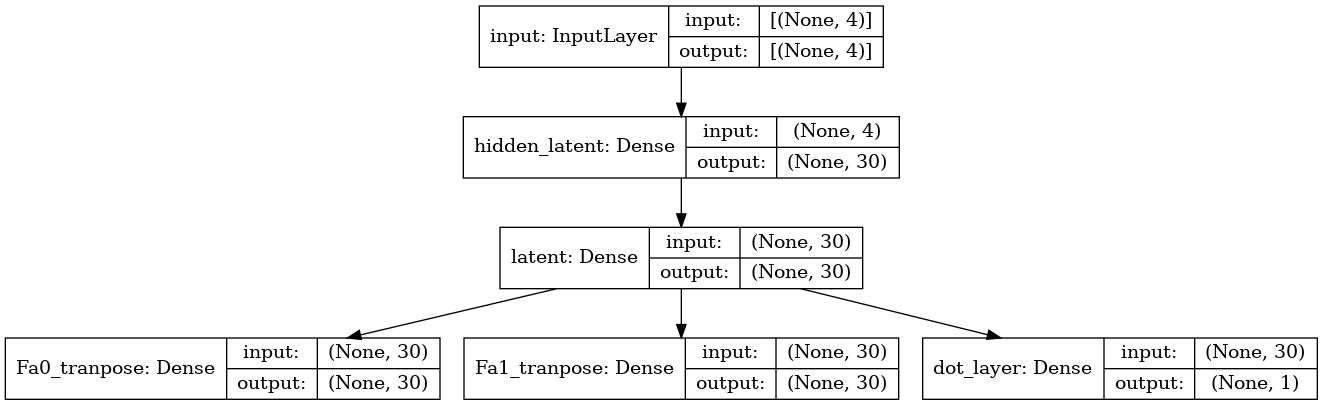

In [8]:

keras.utils.plot_model(agent.model, "my_first_model.png", show_shapes=True)



# Run

In [ ]:
%%time

data_train = []

steps = 0
render = False

reward_cumul = 0

action_space = np.arange(env.action_space.n)
possible_action = action_space


for i in range(num_episodes):
    state = env.reset()

    reward_ep_cumul = 0
    cnt = 0
    avg_loss = 0
    while True:
        if render:
            env.render()
      
        action, eps = agent.choose_action(state, agent.model, steps, possible_action)
            
        next_state, reward, done, info = env.step(action)

        if RANDOM_REWARD_STD > 0:
            reward = np.random.normal(1.0, RANDOM_REWARD_STD)

#         print("state: ", state)
#         print("action : ", action)
#         print("reward: ", reward)
#         print("next_state : ", next_state)
#         print("done : ",  done)
#         print("-------------------- \n")

        reward_ep_cumul += reward
        reward_cumul += reward
        if done:
            next_state = None
        # store in memory
        memory.add_sample((state, action, reward, next_state, done))

        loss = agent.train(agent.model, memory, agent.model_prev if double_model else None, filter_done)
        
        avg_loss += loss

        state = next_state

        # exponentially decay the eps value
        steps += 1
#         eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)

        if done:
            if cnt != 0:
                avg_loss /= cnt
            else:
                avg_loss = 0
            result = [i, cnt, steps, reward_ep_cumul,
                      reward_cumul, avg_loss, eps]

            print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, avg loss: {:0.4f}, eps: {:0.4f} ".format(*result))

            data_train.append(result)
#             with train_writer.as_default():
#                 tf.summary.scalar('reward', cnt, step=i)
#                 tf.summary.scalar('avg loss', avg_loss, step=i)
            break

        cnt += 1

Episode: 000, step: 023, cumul_step: 0024, Reward: 24.0, Reward_cumul: 24.0, avg loss: 0.0000, eps: 0.9887 
Episode: 001, step: 023, cumul_step: 0048, Reward: 24.0, Reward_cumul: 48.0, avg loss: 0.0000, eps: 0.9770 
Episode: 002, step: 020, cumul_step: 0069, Reward: 21.0, Reward_cumul: 69.0, avg loss: 0.0000, eps: 0.9669 
Episode: 003, step: 018, cumul_step: 0088, Reward: 19.0, Reward_cumul: 88.0, avg loss: 0.0000, eps: 0.9579 
Episode: 004, step: 016, cumul_step: 0105, Reward: 17.0, Reward_cumul: 105.0, avg loss: 0.3350, eps: 0.9498 
Episode: 005, step: 047, cumul_step: 0153, Reward: 48.0, Reward_cumul: 153.0, avg loss: 0.2781, eps: 0.9275 
Episode: 006, step: 051, cumul_step: 0205, Reward: 52.0, Reward_cumul: 205.0, avg loss: 0.0695, eps: 0.9040 
Episode: 007, step: 029, cumul_step: 0235, Reward: 30.0, Reward_cumul: 235.0, avg loss: 0.0255, eps: 0.8907 
Episode: 008, step: 012, cumul_step: 0248, Reward: 13.0, Reward_cumul: 248.0, avg loss: 0.0195, eps: 0.8850 
Episode: 009, step: 033

In [ ]:
data_train_df = pd.DataFrame(data_train, columns=[ "Episode", "Step", "cum_step", "Reward", "Reward_cum", "Avg_loss", "Eps"])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3,figsize=(15, 10))


plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

# See results

In [ ]:
# render = True
# steps = 100000 # on simule un step pour avoir un espilon minimum

# test_num_episodes = 10



# for i in range(test_num_episodes):
#     state = env.reset()
#     cnt = 0
#     avg_loss = 0
#     while True:
#         if render:
#             env.render()
# #         action, eps = random.randint(0, env.action_space.n - 1), 0.01
#         action, eps = agent.choose_action(state, agent.model, steps, possible_action)
    
#         next_state, reward, done, info = env.step(action)
        
# #         reward = np.random.normal(1.0, RANDOM_REWARD_STD)
#         if done:
#             next_state = None

#         state = next_state

#         if done:
#             if cnt != 0 : avg_loss /= cnt
#             else : avg_loss = 0
#             result = [i,cnt,steps, reward_ep_cumul, reward_cumul,avg_loss,eps]
            

#             print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, avg loss: {:0.4f}, eps: {:0.4f} ".format(*result))
            
#             break

#         cnt += 1
# print("step", cnt)
# env.close()

In [ ]:
env.close()